Preparations
- Get the data from `https://qim.compute.dtu.dk/data-repository/index.html`. From the 
Hourglass data, download the file `Hourglass_4X-80kV-Air-9s-1_97um.tif`. It should take around 5 minutes to download.

In [1]:
# Get information about tif file, without loading any data
import tifffile
filename = 'data/Hourglass_4X-80kV-Air-9s-1_97um.tif'

tif = tifffile.TiffFile(filename)
Z = len(tif.pages)
Y, X = tif.pages[0].shape
dtype = tif.pages[0].dtype
tif.close()

print(f'Tiff file has {Z} slices of shape ({Y}, {X}). Data type is {dtype}.')

Tiff file has 994 slices of shape (1014, 976). Data type is uint16.


In [2]:
import numpy as np

# Load the data, while downscaling and reducing bit depth to uint8

def load_data(filename, factor=4, bytes_out=1):
    # bytes_out: 1, 2, 4 or 8 (expected smaller than bytes in)
    
    tif = tifffile.TiffFile(filename)
    Z = len(tif.pages)
    Y, X = tif.pages[0].shape
    dtype_in = tif.pages[0].dtype
    bytes_in = dtype_in.itemsize  # 2 for uint16
    dtype_out = np.dtype(f'uint{8*bytes_out}')
    bits_ratio = (2**8)**(bytes_in - bytes_out)
    V = []
    for z in range(Z%factor//2, Z, factor):
        s_in = tif.pages[z].asarray()
        s_out = s_in[Y%factor//2::factor, X%factor//2::factor]
        V.append((s_out//bits_ratio).astype(dtype_out))
    tif.close()
    V = np.asanyarray(V)
    return V

def load_data_normalize(filename, vrange, factor=4, bytes_out=1):
    
    tif = tifffile.TiffFile(filename)
    Z = len(tif.pages)
    Y, X = tif.pages[0].shape
    dtype_out = np.dtype(f'uint{8*bytes_out}')
    V = []
    for z in range(Z%factor//2, Z, factor):
        s_in = tif.pages[z].asarray()
        s_out = s_in[Y%factor//2::factor, X%factor//2::factor]
        s_out = s_out.astype(float) - vrange[0]
        s_out = s_out/(vrange[1] - vrange[0])
        s_out = np.clip(s_out, 0, 1)
        V.append((s_out * (2**(8*bytes_out)-1)).astype(dtype_out))
    tif.close()
    V = np.asanyarray(V)
    return V


def load_data_normalize_crop(filename, vrange, dims, factor=4, bytes_out=1):
    
    tif = tifffile.TiffFile(filename)
    Z = len(tif.pages)
    Y, X = tif.pages[0].shape
    dtype_out = np.dtype(f'uint{8*bytes_out}')
    
    V = []
    for z in range(dims[0][0], dims[0][1], factor):
        s_in = tif.pages[z].asarray()
        s_out = s_in[dims[1][0]:dims[1][1]:factor, dims[2][0]:dims[2][1]:factor]
        s_out = s_out.astype(float) - vrange[0]
        s_out = s_out/(vrange[1] - vrange[0])
        s_out = np.clip(s_out, 0, 1)
        V.append((s_out * (2**(8*bytes_out)-1)).astype(dtype_out))
    tif.close()
    V = np.asanyarray(V)
    return V



In [3]:
vol = load_data_normalize_crop(filename, [25*256, 140*256], [[75*4, 175*4]]*3, factor=1)
print(vol.shape)
Z, Y, X = vol.shape

(400, 400, 400)


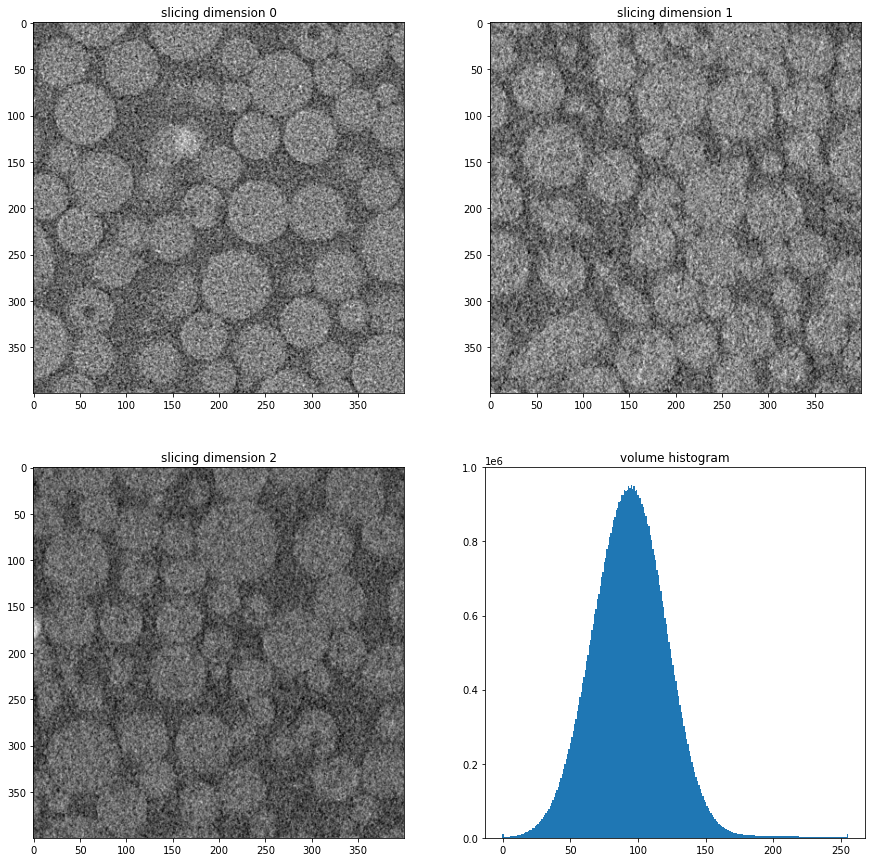

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()
ax[0].imshow(vol[Z//2], cmap=plt.cm.gray)
ax[0].set_title('slicing dimension 0')
ax[1].imshow(vol[:, Y//2, :], cmap=plt.cm.gray)
ax[1].set_title('slicing dimension 1')
ax[2].imshow(vol[:, :, X//2], cmap=plt.cm.gray)
ax[2].set_title('slicing dimension 2')
ax[3].hist(vol.ravel(), np.arange(257)-0.5)
ax[3].set_title('volume histogram')
plt.show()

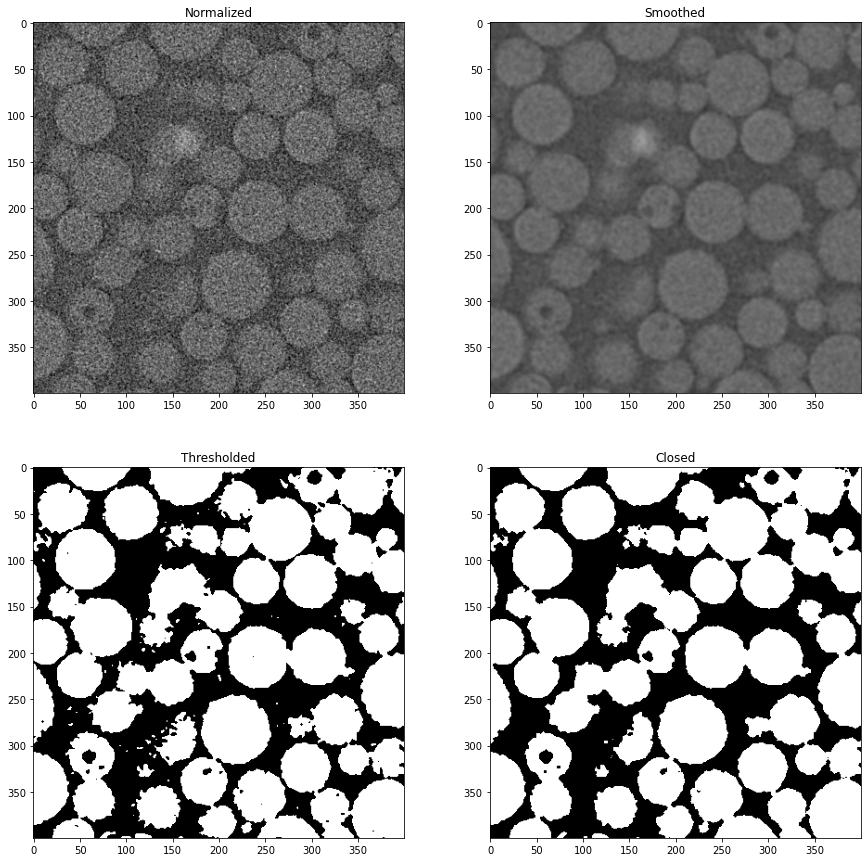

In [10]:
import skimage

# Binarize the volume and visualize all processing steps on one slice.

bin_vol = vol

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

bin_vol = bin_vol.astype(float)/255
ax[0].imshow(bin_vol[Z//2, ], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_title('Normalized')

bin_vol = skimage.filters.gaussian(bin_vol, sigma=1.5)
ax[1].imshow(bin_vol[Z//2], cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_title('Smoothed')

bin_vol = bin_vol > 90/255
ax[2].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[2].set_title('Thresholded')

bin_vol = skimage.morphology.binary_opening(bin_vol, skimage.morphology.ball(2))
bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(2))
ax[3].imshow(bin_vol[Z//2], cmap=plt.cm.gray)
ax[3].set_title('Morphology filtered')

plt.show()
